# Wildfire Hazard Potential for the United States (270-m), version 2023 (4th Edition)

Dataset source: https://www.fs.usda.gov/rds/archive/products/RDS-2015-0047-4/_fileindex_RDS-2015-0047-4.html

Documentation: https://firelab.org/sites/default/files/2024-02/whp2023_cls_conus_metadata.pdf

https://data-usfs.hub.arcgis.com/datasets/usfs::wildfire-hazard-potential-version-2023-classified-image-service/explore?location=35.134247%2C-116.251988%2C6.95

https://www.fs.usda.gov/rds/archive/catalog/RDS-2015-0047-4

Note: 
five WHP classes of very low, low, moderate, high, and very high

## Data dictionary

VALUE = Class (1 = very low, 2 = low, 3 = moderate, 4 = high, 5 = very high, 6 = non-burnable, 7 = water)

https://www.fs.usda.gov/rds/archive/products/RDS-2015-0047-4/_metadata_RDS-2015-0047-4.html

In [18]:
import geopandas as gpd
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import rioxarray
import random
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling

In [2]:
whp_filename = 'data/Data-2/whp2023_GeoTIF/whp2023_cls_conus.tif'

# Rough Crop

In [3]:
with rasterio.open(whp_filename) as src:

    # The size in pixels of your desired window
    xsize, ysize = 4096, src.height # 512
    bounds = src.bounds

    # Extract xmin, ymin, xmax, ymax
    xmin, ymin, xmax, ymax = bounds.left, bounds.bottom, bounds.right, bounds.top

    # Generate a random window origin (upper left) that ensures the window 
    # doesn't go outside the image. i.e. origin can only be between 
    # 0 and image width or height less the window width or height
    xmin, xmax = 0, src.width - xsize
    ymin, ymax = 0, src.height - ysize
    #xoff, yoff = random.randint(xmin, xmax), random.randint(ymin, ymax)

    xoff, yoff = xmin, ymin
    # Create a Window and calculate the transform from the source dataset    
    window = Window(xoff, yoff, xsize, ysize)
    transform = src.window_transform(window)

    # Create a new cropped raster to write to
    profile = src.profile
    profile.update({
        'height': ysize,
        'width': xsize,
        'transform': transform})

    with rasterio.open('output/temp_crop.tif', 'w', **profile) as dst:
        # Read the data from the window and write it to the output raster
        dst.write(src.read(window=window))

In [4]:
src.width

17372

In [5]:
src.height

11283

In [6]:
bounds.bottom, bounds.top

(221264.99999999814, 3267674.999999998)

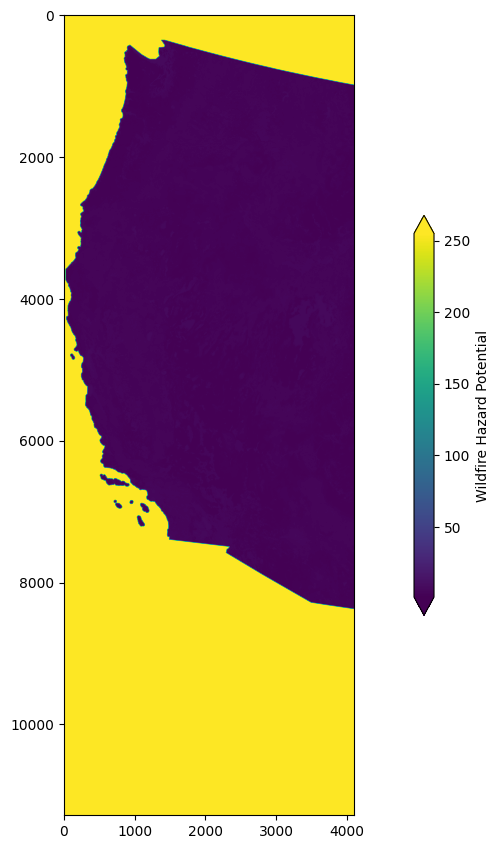

In [7]:
xds = rioxarray.open_rasterio("output/temp_crop.tif")
#xds.plot()

fig = plt.figure(figsize=[12,8])
ax = fig.add_axes([0, 0, 1, 1])

raster_image = ax.imshow(xds[0, :, :]) #, vmax=5000, vmin=-5000)

# Pass the raster_image to colorbar(), not xds
fig.colorbar(raster_image, ax=ax, label="Wildfire Hazard Potential", orientation='vertical', extend='both', shrink=0.5)

# Resample to 20km grid

In [8]:
# Path to your input TIFF file
input_tif = 'output/temp_crop.tif'
output_tif = 'output/temp_crop_2km.tif'

# Define the original and target resolution
original_resolution = 270  # meters
target_resolution = 20000  # meters

# Open the original dataset
with rasterio.open(input_tif) as src:
    # Calculate the scale factor (since we are upscaling, it's target/original)
    scale_factor = target_resolution / original_resolution
    
    # Calculate the new width and height
    new_width = int(src.width / scale_factor)
    new_height = int(src.height / scale_factor)
    
    # Read the data and resample it to the new dimensions
    data = src.read(
        out_shape=(src.count, new_height, new_width),
        resampling=Resampling.average  # You can use bilinear, cubic, or others as per your needs
    )
    
    # Update the transform to reflect the new resolution
    transform = src.transform * src.transform.scale(
        (src.width / new_width),  # Scale factor in x direction
        (src.height / new_height)  # Scale factor in y direction
    )
    
    # Save the resampled dataset to a new TIFF file
    with rasterio.open(
        output_tif, 'w',
        driver='GTiff',
        height=new_height,
        width=new_width,
        count=src.count,
        dtype=data.dtype,
        crs=src.crs,
        transform=transform,
    ) as dst:
        dst.write(data)


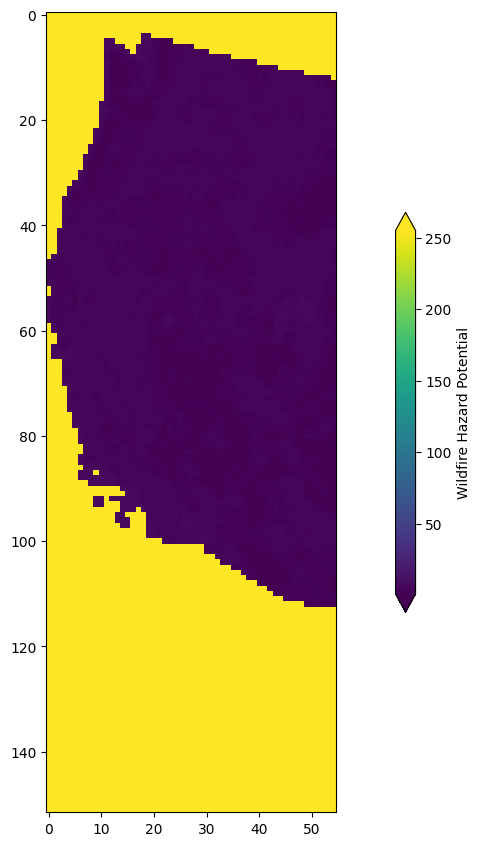

In [9]:
xds = rioxarray.open_rasterio(output_tif)
#xds.plot()

fig = plt.figure(figsize=[12,8])
ax = fig.add_axes([0, 0, 1, 1])

raster_image = ax.imshow(xds[0, :, :]) #, vmax=5000, vmin=-5000)

# Pass the raster_image to colorbar(), not xds
fig.colorbar(raster_image, ax=ax, label="Wildfire Hazard Potential", orientation='vertical', extend='both', shrink=0.5)

# California bounding box 

From: https://observablehq.com/@rdmurphy/u-s-state-bounding-boxes

-124.41060660766607,32.5342307609976,-114.13445790587905,42.00965914828148

In [10]:
import rasterio
from rasterio.warp import transform, transform_bounds
from rasterio.mask import mask
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box, Point
import matplotlib.pyplot as plt

# Define the bounding box in WGS84 (longitude, latitude)
min_lon, min_lat, max_lon, max_lat = -124.41060660766607, 32.5342307609976, -114.13445790587905, 42.00965914828148
bounding_box = box(min_lon, min_lat, max_lon, max_lat)

# Open the raster file
with rasterio.open(output_tif) as src:
    # Transform the bounding box from WGS84 to the native CRS of the raster
    minx, miny, maxx, maxy = transform_bounds({'init': 'EPSG:4326'}, src.crs, min_lon, min_lat, max_lon, max_lat)
    
    # Create the bounding box in the raster's native CRS
    raster_bbox = [box(minx, miny, maxx, maxy)]
    
    # Crop the raster using the bounding box
    out_image, out_transform = mask(src, raster_bbox, crop=True)
    
    # Get the affine transform of the cropped image
    cropped_data = out_image[0]  # Assuming single-band raster
    
    # Create a meshgrid of row, col indices for the cropped dataset
    rows, cols = np.meshgrid(np.arange(cropped_data.shape[0]), np.arange(cropped_data.shape[1]), indexing='ij')
    
    # Convert pixel indices to projected coordinates (x, y in the native CRS)
    xs, ys = rasterio.transform.xy(out_transform, rows, cols)
    
    # Flatten the arrays
    xs_flat = np.array(xs).flatten()
    ys_flat = np.array(ys).flatten()
    
    # Transform the projected coordinates back to WGS84 (longitude, latitude)
    lon, lat = transform(src.crs, {'init': 'EPSG:4326'}, xs_flat, ys_flat)

# Create a DataFrame for the cropped data
df = pd.DataFrame({
    'longitude': lon,
    'latitude': lat,
    'value': cropped_data.flatten()  # Pixel values (raster values)
})

# Filter out any rows where 'value' is masked or NaN
df = df.dropna(subset=['value'])

In [11]:
df.value.value_counts()

value
4      760
3      693
2      411
255    383
5      297
1      114
7       63
6       51
Name: count, dtype: int64

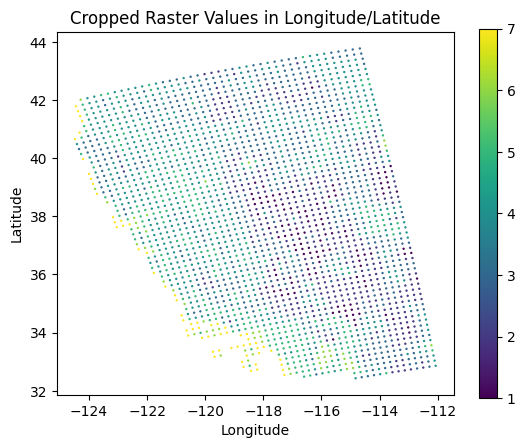

In [13]:
# Convert the DataFrame to a GeoDataFrame
df = df[df.value != 255]

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Plot the GeoDataFrame
gdf.plot(column='value', legend=True, cmap='viridis', markersize=0.5)
plt.title('Cropped Raster Values in Longitude/Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [24]:
shf = gpd.read_file('/Users/anatrisovic/Projects/coexposure/data/shapefiles/tl_2019_06_tract/tl_2019_06_tract.shp')

In [26]:
shf.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,037,139301,06037139301,1393.01,Census Tract 1393.01,G5020,S,2865657,0,+34.1781538,-118.5581265,"POLYGON ((-118.57150 34.17758, -118.57148 34.1..."
1,06,037,139302,06037139302,1393.02,Census Tract 1393.02,G5020,S,338289,0,+34.1767230,-118.5383655,"POLYGON ((-118.54073 34.18019, -118.54070 34.1..."
2,06,037,139502,06037139502,1395.02,Census Tract 1395.02,G5020,S,1047548,0,+34.1628402,-118.5263110,"POLYGON ((-118.53225 34.16201, -118.53177 34.1..."
3,06,037,139600,06037139600,1396,Census Tract 1396,G5020,S,2477482,0,+34.1640599,-118.5101001,"POLYGON ((-118.51858 34.15858, -118.51858 34.1..."
4,06,037,139701,06037139701,1397.01,Census Tract 1397.01,G5020,S,3396396,2411,+34.1574290,-118.4954117,"POLYGON ((-118.50980 34.15691, -118.50848 34.1..."


<Axes: >

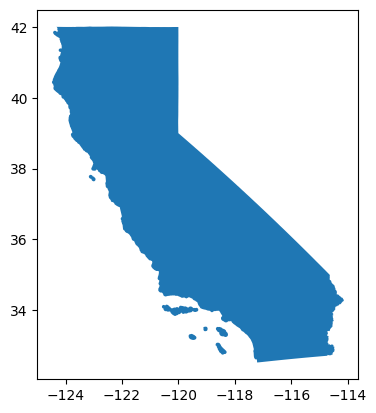

In [27]:
shfca = shf.dissolve(by='STATEFP')
shfca.plot()

In [28]:
shfca

,geometry,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
STATEFP,,,,,,,,,,,,
06,"MULTIPOLYGON (((-122.58329 37.77127, -122.5847...",037,139301,06037139301,1393.01,Census Tract 1393.01,G5020,S,2865657,0,+34.1781538,-118.5581265


In [31]:
shfca = shfca.to_crs("EPSG:4326")

# Perform spatial join to find points within state polygons
points_in_states = gpd.sjoin(gdf, shfca, how='inner', op='within')

/Users/anatrisovic/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/lc/q1l1y0k176b0h_m5yz0s_r5w0000gn/T/ipykernel_49734/326782575.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  points_in_states = gpd.sjoin(gdf, shfca, how='inner', op='within')


<Axes: >

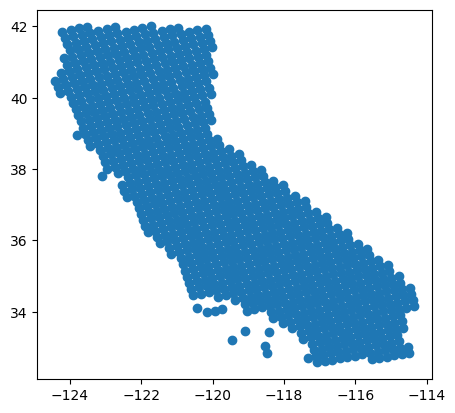

In [33]:
points_in_states.plot()

In [34]:
dissolved_gdf = gpd.read_file("grid_20km_risk_map_CA.geojson")

In [43]:
dissolved_gdf = dissolved_gdf.to_crs("EPSG:4326")
dissolved_gdf.head()

,Allocated_Population,wfday,smoke_pm_gt_five,risk,perc_risk,x,y,geometry
0,705.599506,19.5,154.5,561.705600,13.385808,-2.339420e+06,699418.132435,"POLYGON ((-124.35771 40.56029, -124.33480 40.6..."
1,1220.310637,22.5,185.0,668.720311,15.936038,-2.343895e+06,684797.492112,"POLYGON ((-124.19447 40.45582, -124.17782 40.4..."
2,1222.935077,20.5,194.0,685.722935,16.341221,-2.345059e+06,665492.486339,"POLYGON ((-124.12217 40.24103, -124.28832 40.2..."
3,498.609386,20.5,194.0,684.998609,16.323960,-2.341493e+06,648001.876010,"POLYGON ((-124.03957 40.07338, -124.08067 40.0..."
4,54.831789,22.5,252.0,868.554832,20.698224,-2.337892e+06,631936.632812,"POLYGON ((-124.00632 39.98556, -124.01291 39.9..."


In [41]:
dissolved_gdf.drop(columns=['index'], inplace=True)

In [46]:
merged_gdf = gpd.sjoin(points_in_states, dissolved_gdf, how='left', predicate='within', lsuffix='_left', rsuffix='_right')

/var/folders/lc/q1l1y0k176b0h_m5yz0s_r5w0000gn/T/ipykernel_49734/877155414.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  merged_gdf = gpd.sjoin(points_in_states, dissolved_gdf, how='left', predicate='within', lsuffix='_left', rsuffix='_right')


In [49]:
len(dissolved_gdf)

1132

<Axes: >

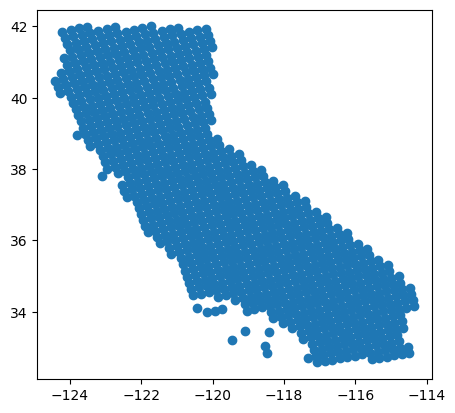

In [52]:
merged_gdf.plot()

In [55]:
merged_gdf.columns

Index(['longitude', 'latitude', 'value', 'geometry', 'index_right', 'COUNTYFP',
       'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'index__right',
       'Allocated_Population', 'wfday', 'smoke_pm_gt_five', 'risk',
       'perc_risk', 'x', 'y'],
      dtype='object')

In [56]:
merged_gdf[['x','y','value', 'longitude', 'latitude']].to_csv('output/whp2023_cls_ca_20km_grid_revised.csv', index=False)

In [22]:
#gdf[['longitude', 'latitude', 'value']].to_csv('output/whp2023_cls_ca_20km_grid.csv', index=False)